In [2]:
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
import joblib

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

In [2]:
seed = 42

In [3]:
coin = 'KRW-SXP'

In [4]:
df = pd.read_csv(f'../data/from_pyupbit/{coin}.csv')

In [5]:
df

,timestamp,open,high,low,close,volume,value
0,2020-12-26 13:11:00,777.0,777.0,777.0,777.0,2350.713400,1.826504e+06
1,2020-12-26 13:12:00,777.0,777.0,777.0,777.0,1630.621294,1.266993e+06
2,2020-12-26 13:13:00,777.0,778.0,777.0,778.0,1128.288067,8.771163e+05
3,2020-12-26 13:15:00,777.0,777.0,777.0,777.0,6474.727887,5.030864e+06
4,2020-12-26 13:16:00,778.0,778.0,777.0,777.0,7533.733012,5.854151e+06
...,...,...,...,...,...,...,...
1576795,2024-10-12 18:32:00,390.4,391.0,389.9,391.0,350074.951992,1.366919e+08
1576796,2024-10-12 18:33:00,390.9,391.9,390.7,391.4,181924.275797,7.114177e+07
1576797,2024-10-12 18:34:00,391.4,392.1,391.3,391.8,221882.023167,8.694523e+07
1576798,2024-10-12 18:35:00,391.5,393.5,391.5,392.6,398580.407319,1.564076e+08


In [5]:
df['timestamp'] = pd.to_datetime(df['timestamp'])
df.set_index('timestamp', inplace=True)

In [7]:
df

,open,high,low,close,volume,value
timestamp,,,,,,
2020-12-26 13:11:00,777.0,777.0,777.0,777.0,2350.713400,1.826504e+06
2020-12-26 13:12:00,777.0,777.0,777.0,777.0,1630.621294,1.266993e+06
2020-12-26 13:13:00,777.0,778.0,777.0,778.0,1128.288067,8.771163e+05
2020-12-26 13:15:00,777.0,777.0,777.0,777.0,6474.727887,5.030864e+06
2020-12-26 13:16:00,778.0,778.0,777.0,777.0,7533.733012,5.854151e+06
...,...,...,...,...,...,...
2024-10-12 18:32:00,390.4,391.0,389.9,391.0,350074.951992,1.366919e+08
2024-10-12 18:33:00,390.9,391.9,390.7,391.4,181924.275797,7.114177e+07
2024-10-12 18:34:00,391.4,392.1,391.3,391.8,221882.023167,8.694523e+07


In [6]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df['close'].values.reshape(-1, 1))
joblib.dump(scaler, f'models/{coin}_scaler.pkl')

['models/KRW-SXP_scaler.pkl']

In [7]:
timestep = 1

In [8]:
X = []
y = []
for i in range(len(scaled_data) - timestep - 1):
    X.append(scaled_data[i:(i + timestep), 0])
    y.append(scaled_data[i + timestep, 0])

In [9]:
X, y = np.array(X), np.array(y)

In [14]:
print(X.shape, y.shape)

(1576798, 1) (1576798,)


In [11]:
train_size = int(len(X) * .8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

In [12]:
train_dates = df.index[:train_size]
test_dates = df.index[train_size:]

In [15]:
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [16]:
print(X_train.shape, X_test.shape)

(1261438, 1, 1) (315360, 1, 1)


In [17]:
print(y_train.shape, y_test.shape)

(1261438,) (315360,)


In [15]:
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(timestep, 1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

In [16]:
model.compile(optimizer='adam', loss='mean_squared_error')

In [17]:
early_stop = EarlyStopping(monitor='val_loss', patience=10)

In [18]:
model.fit(X_train, y_train, batch_size=32, epochs=20,
          validation_data=(X_test, y_test), callbacks=[early_stop])

Epoch 1/20
39420/39420 [==============================] - 194s 5ms/step - loss: 4.9613e-05 - val_loss: 1.0677e-07
Epoch 2/20
39420/39420 [==============================] - 630s 16ms/step - loss: 2.1204e-06 - val_loss: 9.8793e-07
Epoch 3/20
39420/39420 [==============================] - 637s 16ms/step - loss: 1.9217e-06 - val_loss: 1.0085e-07
Epoch 4/20
39420/39420 [==============================] - 678s 17ms/step - loss: 1.7270e-06 - val_loss: 1.0359e-06
Epoch 5/20
39420/39420 [==============================] - 649s 16ms/step - loss: 1.6358e-06 - val_loss: 2.2677e-07
Epoch 6/20
39420/39420 [==============================] - 660s 17ms/step - loss: 1.5647e-06 - val_loss: 2.4620e-07
Epoch 7/20
39420/39420 [==============================] - 671s 17ms/step - loss: 1.5052e-06 - val_loss: 9.5158e-07
Epoch 8/20
39420/39420 [==============================] - 649s 16ms/step - loss: 1.4732e-06 - val_loss: 1.5838e-06
Epoch 9/20
39420/39420 [==============================] - 664s 17ms/step - loss: 

In [42]:
model.save(f'models/lstm_{coin}.h5')

In [20]:
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

9855/9855 [==============================] - 15s 2ms/step


In [21]:
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)
y_train = scaler.inverse_transform([y_train])
y_test = scaler.inverse_transform([y_test])

In [22]:
train_score = np.sqrt(mean_squared_error(y_train[0], train_predict[:, 0]))
test_score = np.sqrt(mean_squared_error(y_test[0], test_predict[:, 0]))
print(f'Train RMSE: {train_score:.2f}')
print(f'Test RMSE: {test_score:.2f}')

Train RMSE: 9.70
Test RMSE: 2.32


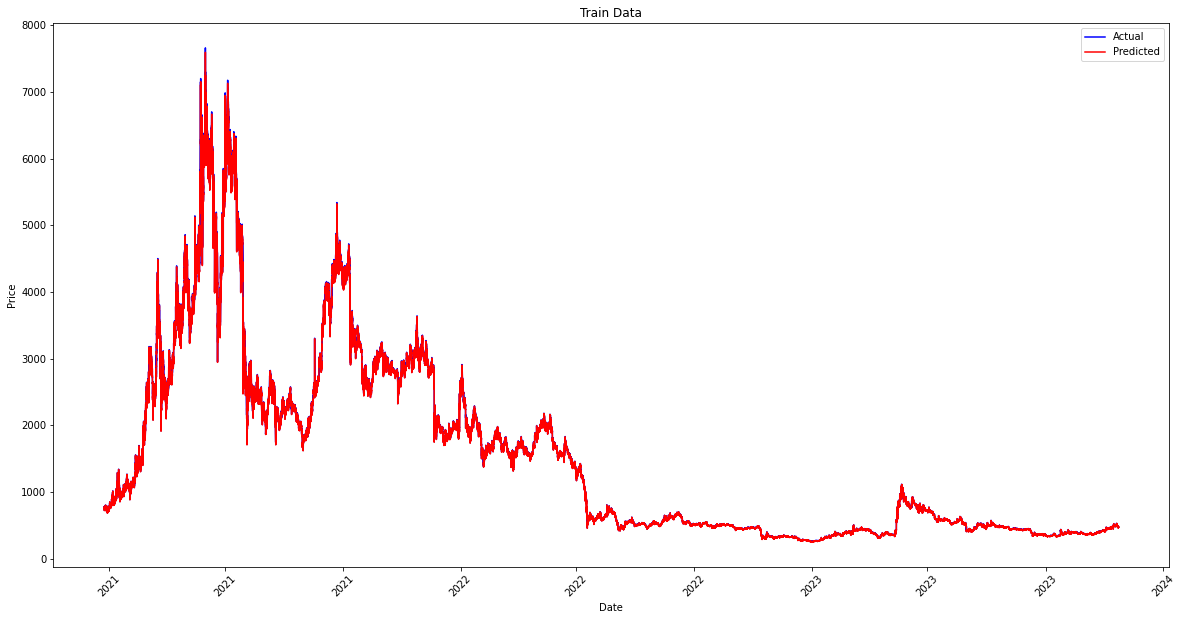

In [23]:
plt.figure(figsize=(20, 10))
plt.subplot(1, 1, 1)
plt.plot(train_dates, y_train[0], label='Actual', color = 'Blue')
plt.plot(train_dates, train_predict, label='Predicted', color = 'Red')
plt.title('Train Data')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.xticks(rotation=45)
plt.gca().xaxis.set_major_formatter(DateFormatter('%Y'))

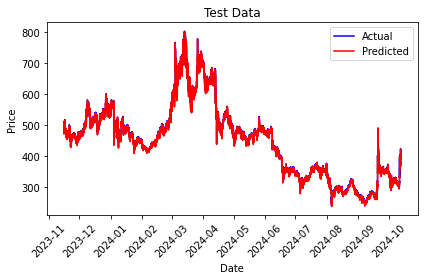

In [37]:
plt.subplot(1, 1, 1)
plt.plot(test_dates[:-2], y_test[0], label='Actual', color = 'Blue')
plt.plot(test_dates[:-2], test_predict, label='Predicted', color = 'Red')
plt.title('Test Data')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.xticks(rotation=45)
plt.gca().xaxis.set_major_formatter(DateFormatter('%Y-%m'))

plt.tight_layout()
plt.show()

In [38]:
last_1_day = scaled_data[-timestep:]
X_predict = last_1_day.reshape(1, timestep, 1)
print(last_1_day)

[[0.02063342]]


In [39]:
pred = model.predict(X_predict)
pred = scaler.inverse_transform(pred)
print(pred)

1/1 [==============================] - 0s 18ms/step
[[391.04007]]


In [40]:
preds = []
for i in range(30):
    pred = model.predict(X_predict)
    preds.append(scaler.inverse_transform(pred)[0][0])
    pred = pred.reshape(1, 1, 1)
    X_predict = pred

1/1 [==============================] - 0s 13ms/step


In [41]:
preds

[391.04007,
 388.97977,
 386.9189,
 384.8575,
 382.79544,
 380.73294,
 378.66956,
 376.6056,
 374.54077,
 372.47537,
 370.40912,
 368.34186,
 366.27393,
 364.205,
 362.1352,
 360.06427,
 357.99225,
 355.91913,
 353.8449,
 351.76935,
 349.69257,
 347.6146,
 345.53528,
 343.45474,
 341.37277,
 339.28937,
 337.2042,
 335.11758,
 333.02942,
 330.9397]